## TODO
* Implement first order low pass filter for controller using coefficients calculated for 20ms sample time and cut-off frequency $1 Hz$  
The coefficients are: $ A_{0} = 1; A_{1} = 0.88176521; B_{0} = 0.0591174; B_{1} = 0.0591174 $. The equation is:

$$ y_{filt}[i] = a_{1}y_{filt}[i-1] + b_{0}y_{i} + b_{1}y_{i-1} \tag{1}$$
* Add legend to the last plot

In [1]:
import csv
%matplotlib widget
import matplotlib.pyplot as plt

import numpy as np
from scipy import signal

# Plot the signal
# plt.clf()
# plt.close()

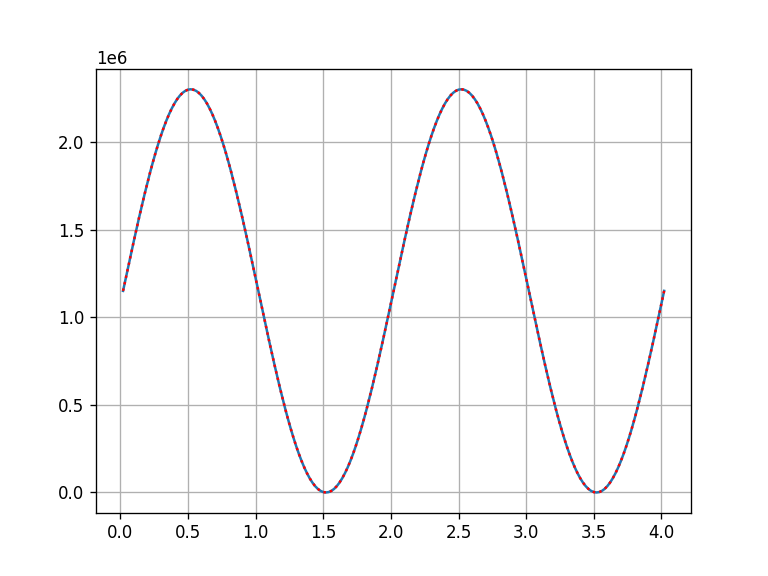

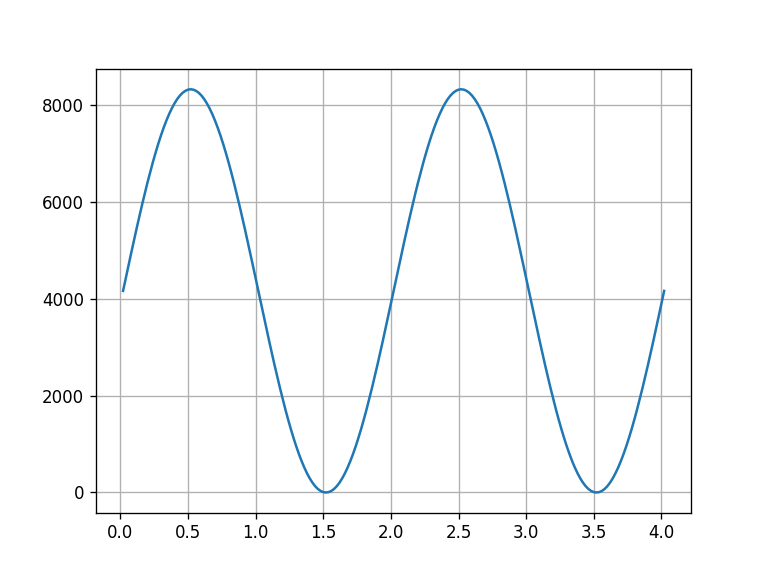

In [2]:
path = "sinSig.csv"
csv_file = open(path, newline='')
header = next(csv_file)
reader = csv.reader(csv_file)

pwr = []
t = []
pwrInt = []
pwrPcntg = []
for row in reader:
    power = float(row[0])
    time = float(row[1])
    powerInt = int(row[2])
    powerPercentage = int(row[3])
    t.append([time])
    pwr.append([power])
    pwrInt.append([powerInt])
    pwrPcntg.append([powerPercentage])

plt.clf()
plt.close()
plt.figure(dpi = 120)
plt.plot(t, pwr )
plt.plot(t, pwrInt, 'r', linestyle='dotted')
plt.grid()
plt.show()
# plt.clf()


# plt.close()
plt.figure(dpi = 120)
plt.plot(t, pwrPcntg)
plt.grid()
plt.show()
# plt.clf()


# plt.figure(dpi = 120)
# plt.plot(t, pwrInt)
# # current_values = plt.gca().get_yticks()
# # # using format string '{:.0f}' here but you can choose others
# # plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])
# plt.grid()
# plt.show()

# for i in range(len(data) - 1):

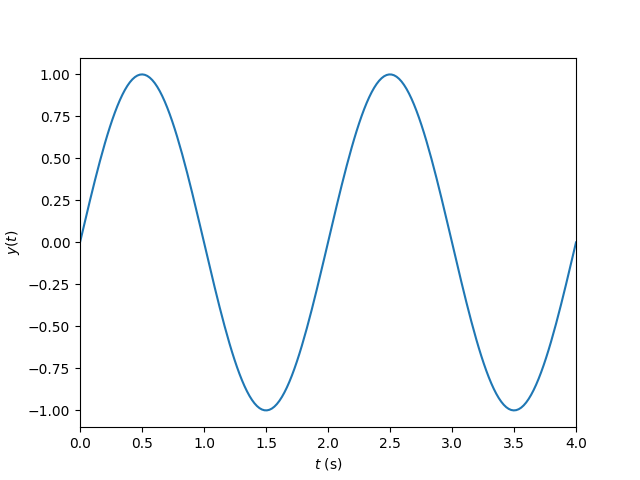

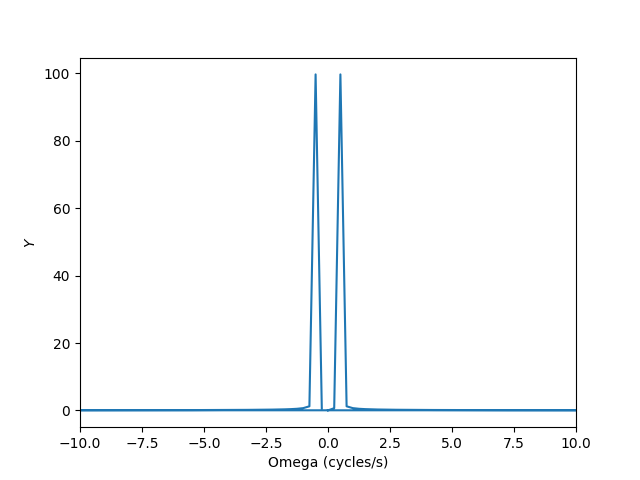

In [3]:
# Generate a signal
samplingFreq = 50; # sampled at 1 kHz = 1000 samples / second
tlims = [0,4]        # in seconds
signalFreq = [0.5,5]; # Cycles / second
signalMag = [1,0.0]; # magnitude of each sine
t = np.linspace(tlims[0],tlims[1],(tlims[1]-tlims[0])*samplingFreq)
y = signalMag[0]*np.sin(2*np.pi*signalFreq[0]*t) + signalMag[1]*np.sin(2*np.pi*signalFreq[1]*t)

# Compute the Fourier transform
yhat = np.fft.fft(y);
fcycles = np.fft.fftfreq(len(t),d=1.0/samplingFreq); # the frequencies in cycles/s

# Plot the signal
# plt.clf()
plt.figure()
plt.plot(t,y);
plt.ylabel("$y(t)$");
plt.xlabel("$t$ (s)");
plt.xlim([min(t),max(t)]);
plt.show()

# Plot the power spectrum
plt.figure()
plt.plot(fcycles,np.absolute(yhat));
plt.xlim([-10,10]);
plt.xlabel("Omega (cycles/s)");
plt.ylabel("$Y$");

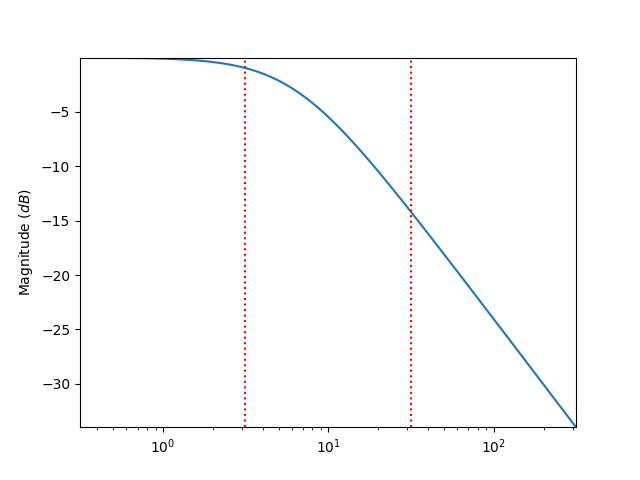

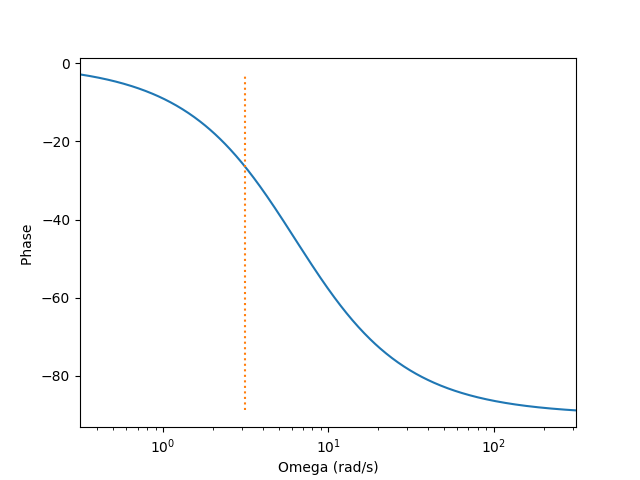

In [4]:
# Low-pass filter
w0 = 2*np.pi*1; # pole frequency (rad/s)
num = w0        # transfer function numerator coefficients
den = [1,w0]    # transfer function denominator coefficients
lowPass = signal.TransferFunction(num,den) # Transfer function

# Generate the bode plot
w = np.logspace( np.log10(min(signalFreq)*2*np.pi/10), np.log10(max(signalFreq)*2*np.pi*10), 500 )
w, mag, phase = signal.bode(lowPass,w)

# Plot the signal
# plt.clf()
# Magnitude plot
plt.figure()
plt.semilogx(w, mag)
for sf in signalFreq:
    plt.semilogx([sf*2*np.pi,sf*2*np.pi],[min(mag),max(mag)],'r:')
plt.ylabel("Magnitude ($dB$)")
plt.xlim([min(w),max(w)])
plt.ylim([min(mag),max(mag)])
plt.show()

# Phase plot
plt.figure()
plt.semilogx(w, phase)  # Bode phase plot
plt.semilogx([2*np.pi*0.5, 2*np.pi*0.5], [min(phase), max(phase)], ':')
plt.ylabel("Phase ")
plt.xlabel("Omega (rad/s)")
plt.xlim([min(w),max(w)])
plt.show()

In [5]:
dt = 1.0/samplingFreq;
discreteLowPass = lowPass.to_discrete(dt,method='gbt',alpha=0.5)
print(discreteLowPass)

TransferFunctionDiscrete(
array([0.0591174, 0.0591174]),
array([ 1.        , -0.88176521]),
dt: 0.02
)


Filter coefficients b_i: [0.0591174 0.0591174]
Filter coefficients a_i: [0.88176521]


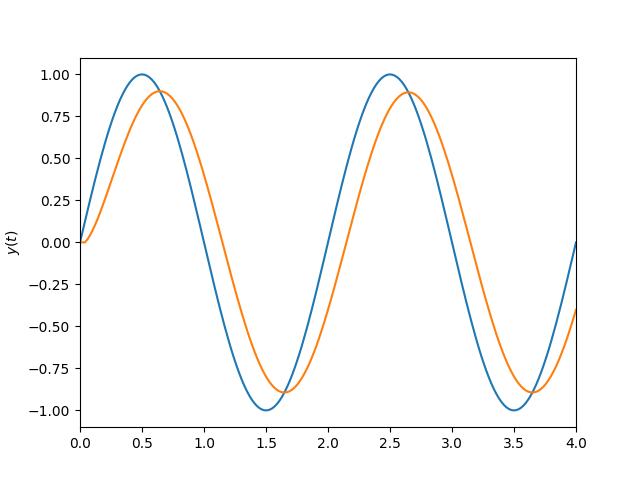

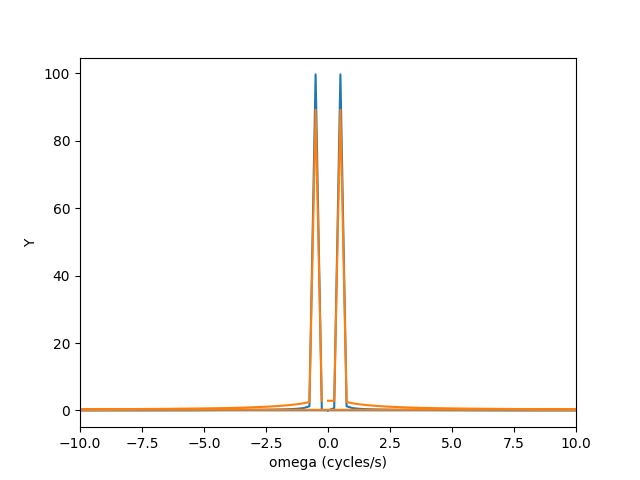

In [6]:
# The coefficients from the discrete form of the filter transfer function (but with a negative sign)
b = discreteLowPass.num;
a = -discreteLowPass.den;
print("Filter coefficients b_i: " + str(b))
print("Filter coefficients a_i: " + str(a[1:]))

# Filter the signal
yfilt = np.zeros(len(y));
for i in range(3,len(y)):
    yfilt[i] = a[1]*yfilt[i-1] + b[0]*y[i] + b[1]*y[i-1];

# Plot the signal
# plt.clf()

# Plot the signal
plt.figure()
plt.plot(t,y);
plt.plot(t,yfilt);
plt.ylabel("$y(t)$")
plt.xlim([min(t),max(t)]);

# Generate Fourier transform
yfilthat = np.fft.fft(yfilt)
fcycles = np.fft.fftfreq(len(t),d=1.0/samplingFreq)

plt.figure()
plt.plot(fcycles,np.absolute(yhat));
plt.plot(fcycles,np.absolute(yfilthat));
plt.xlim([-10,10]);
plt.xlabel("omega (cycles/s)");
plt.ylabel("Y");

## T409 Flux Control Data

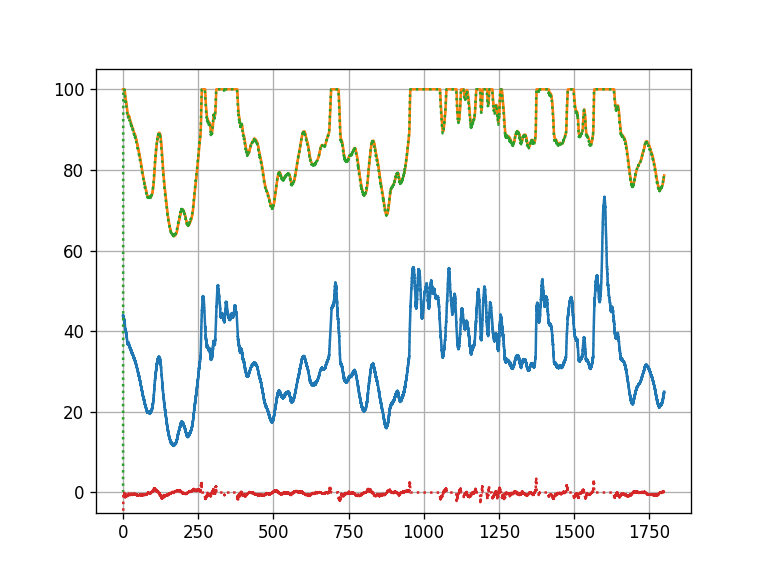

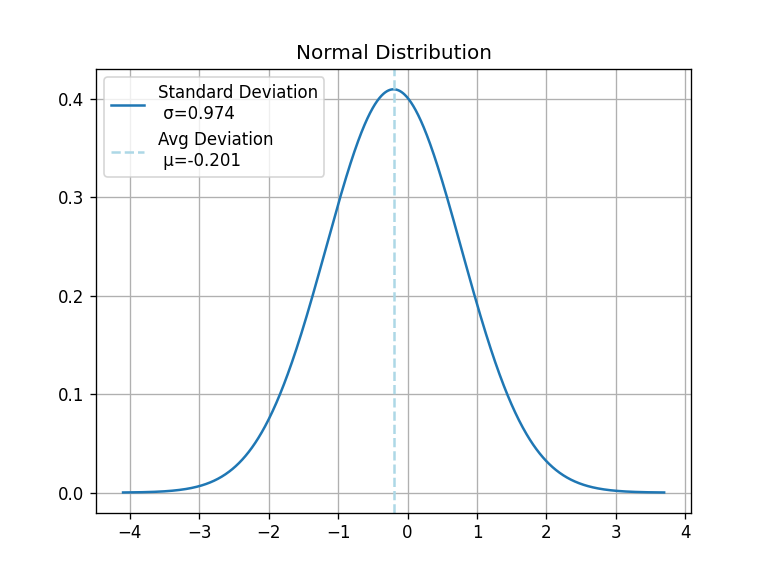

In [74]:
#Read trigger log
path = "HRL1.csv"
HRL_file = open(path, 'r')
reader = csv.DictReader(HRL_file)

count = []
powerRef = []
fluxRef = []

for row in reader:
    count.append(float(row['Column2']))
    powerRef.append(float(row['Column10']) / 100.0)
    fluxRef.append(float(row['Column12']) / 100.0)

#Convert samples to time in seconds assuming that samples are done every 20ms
time_sec = []
for i in count:
    # item = (i * 20.0 / 1000.0)
    time_sec.append(i * 20.0 / 1000.0)

#scale power reference powerRef * 1.6667 + 5000
scaledPowerRef = []
for i in powerRef:
        item = 1.166666 * i + 50.0
        if item > 100.0:
            item = 100.0
        scaledPowerRef.append(item)



#Filter scaled power reference 
fluxRefCalc = np.zeros(len(powerRef));
for i in range(3,len(powerRef)):
    fluxRefCalc[i] = a[1]*fluxRefCalc[i-1] + b[0]*scaledPowerRef[i] + b[1]*scaledPowerRef[i-1]




#Plot the result
plt.figure(dpi=120)
plt.plot(time_sec, powerRef)
plt.plot(time_sec, fluxRef)
plt.plot(time_sec, fluxRefCalc, ':')
plt.plot(time_sec, fluxRefDiff, ':')
plt.ylim(-5, 105)
plt.grid()
plt.show()

#Calculate standard deviation
fluxRefDiff = []
for i in range(0,len(fluxRef)):
    fluxRefDiff.append((fluxRefCalc[i] ) - (fluxRef[i]))

from scipy.stats import norm
std = np.std(fluxRefDiff)
mean = sum(fluxRefDiff) / len(fluxRefDiff)
# print("Standard Deviation " +str(std))
# print("Average Deviation " +str(mean))

#Plot normal distribution
x = np.linspace(mean - 4 * std, mean + 4 * std, 1000)
y = norm(loc=mean, scale=std).pdf(x)

plt.figure(dpi=120)
plt.title(label='Normal Distribution', loc='center')

plt.plot(x, y, label=f"Standard Deviation\n σ={std:.3f}")
plt.axvline(mean, ls="--", color="lightblue", label=f"Avg Deviation\n μ={mean:.3f}")
plt.legend(loc='upper left')
plt.grid()
plt.show()


# plt.savefig("T409.svg")

In [63]:
#clean up the RAM from previous plots
for i in range(0, 35):
    plt.clf()
    plt.close()